# Importing the python modules

In [1]:
import pandas as pd
import numpy as np

In [2]:

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *


In [4]:
defaults.device

device(type='cuda')

# Creating Test and train data variables

In [301]:
test_df=pd.read_csv('./valid-edemaonly.csv')
test_df.head()

,Unnamed: 0,Path,Sex,Age,Frontal/Lateral,AP/PA,Edema
0,0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0
1,1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0
2,3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,1.0
3,4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,0.0
4,5,CheXpert-v1.0-small/valid/patient64545/study1/...,Female,55,Frontal,AP,0.0


In [302]:
test_df.drop(labels=['Unnamed: 0','Sex','Age','Frontal/Lateral','AP/PA'], axis=1, inplace=True)

In [303]:
test_df.Edema.replace([-1.0,1.0,0.0], ['uncertain', 'edema','no_edema'], inplace=True)

In [304]:
test_df.Edema.unique()

array(['no_edema', 'edema'], dtype=object)

In [305]:
train_df = pd.read_csv('./train6/train-edemaonly.csv')
train_df.head()

,Unnamed: 0,Path,Sex,Age,Frontal/Lateral,AP/PA,Edema
0,1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,-1.0
1,4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,1.0
2,16,CheXpert-v1.0-small/train/patient00009/study1/...,Male,76,Frontal,PA,0.0
3,24,CheXpert-v1.0-small/train/patient00011/study7/...,Female,19,Frontal,AP,0.0
4,27,CheXpert-v1.0-small/train/patient00011/study10...,Female,19,Frontal,AP,1.0


In [306]:
train_df.Path[0]

'CheXpert-v1.0-small/train/patient00002/study2/view1_frontal.jpg'

In [307]:
train_df.drop(labels=['Unnamed: 0','Sex','Age','Frontal/Lateral','AP/PA'], axis=1, inplace=True)

In [308]:
train_df.Edema.replace([-1.0,1.0,0.0], ['uncertain', 'edema','no_edema'], inplace=True)

In [309]:
train_df.head()

,Path,Edema
0,CheXpert-v1.0-small/train/patient00002/study2/...,uncertain
1,CheXpert-v1.0-small/train/patient00003/study1/...,edema
2,CheXpert-v1.0-small/train/patient00009/study1/...,no_edema
3,CheXpert-v1.0-small/train/patient00011/study7/...,no_edema
4,CheXpert-v1.0-small/train/patient00011/study10...,edema


# Image Transformations and data splitting

In [310]:
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [11]:
#data = (src.transform(tfms, size=128)
#.databunch().normalize(imagenet_stats))
data = (ImageList.from_df(df, './')
        #Where to find the data? -> in planet 'train' folder
        .random_split_by_pct(0.2)
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df()
        #How to label? -> use the second column of the csv file and split the tags by ' '
        .transform(tfms, size=128)
        #Data augmentation? -> use tfms with a size of 128
        .databunch())

In [311]:
path=Path('./')

In [312]:
train=ImageList.from_df(train_df, './')
test=ImageList.from_df(test_df,path)

In [313]:
test

ImageList (202 items)
Image (3, 320, 390),Image (3, 320, 320),Image (3, 320, 390),Image (3, 320, 390),Image (3, 320, 390)
Path: .

In [314]:
data = (train.random_split_by_pct(0.2, seed=42)
        .label_from_df()
        .add_test(test)
        .transform(tfms, size=128, resize_method=ResizeMethod.PAD, padding_mode='border',)
        .databunch())

In [315]:
data

ImageDataBunch;

Train: LabelList (61927 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
uncertain,edema,no_edema,no_edema,edema
Path: .;

Valid: LabelList (15481 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
edema,no_edema,no_edema,edema,uncertain
Path: .;

Test: LabelList (202 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: .

# Viewing the data after splitting

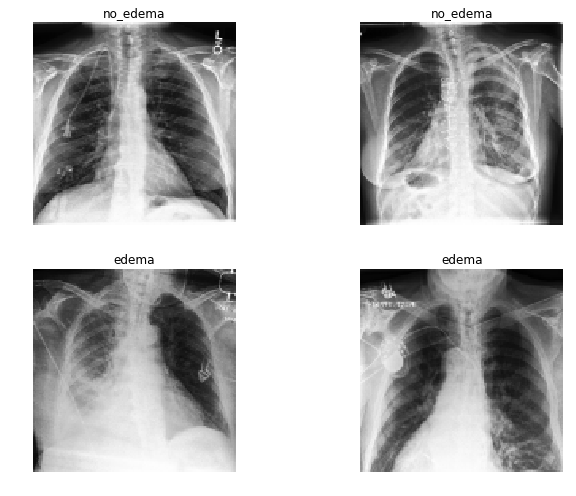

In [13]:
data.show_batch(2, figsize=(10,7))

# Getting the model architecture and training the model

In [101]:
models_list =["models.ResNet","models.unet","models.vgg19_bn","models.xresnet50","models.vgg16_bn"]

In [316]:
arch = models.vgg16_bn

In [317]:
acc_02 = partial(accuracy_thresh, thresh=0.25)
f_score = partial(fbeta, thresh=0.25)
learn = create_cnn(data, arch, metrics=[accuracy, f_score])

In [17]:
#learn.fit(5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


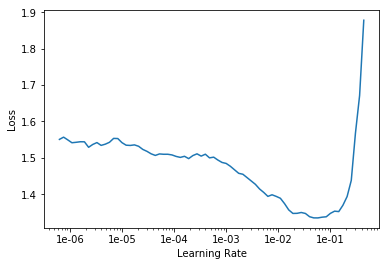

In [18]:
lr_find(learn)
learn.recorder.plot()

In [19]:
lr = 0.001
#try 0.0001

In [20]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
1,0.882535,0.794414,0.686196,02:16
2,0.777944,0.764031,0.692526,02:16
3,0.741949,0.740063,0.702862,02:16
4,0.725804,0.723692,0.710225,02:16
5,0.725918,0.713287,0.709450,02:16
6,0.705053,0.709814,0.712615,02:16
7,0.701359,0.706970,0.713068,02:16
8,0.701861,0.702123,0.714489,02:16
9,0.695220,0.701234,0.715458,02:16
10,0.704890,0.701181,0.715393,02:16


In [21]:
learn.save('vgg16stage1')

In [22]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
1,0.701135,0.703173,0.714683,02:15
2,0.705132,0.702203,0.714037,02:16
3,0.711321,0.699937,0.716685,02:16
4,0.696009,0.700075,0.715522,02:16
5,0.711151,0.698855,0.714941,02:16
6,0.720144,0.695488,0.715070,02:16
7,0.682725,0.694464,0.717783,02:16
8,0.704289,0.693759,0.717718,02:16
9,0.676849,0.693873,0.717331,02:16
10,0.683211,0.693185,0.717912,02:16


In [23]:
learn.save('vgg16stage1')

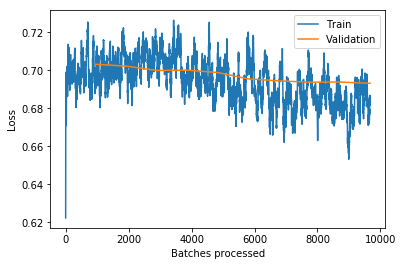

In [24]:
learn.recorder.plot_losses()

In [25]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
1,0.667912,0.695347,0.716943,02:15
2,0.687579,0.696118,0.717266,02:16
3,0.681697,0.696735,0.717008,02:16
4,0.674757,0.696951,0.716491,02:16
5,0.683466,0.694776,0.717202,02:16
6,0.699674,0.691998,0.717848,02:16
7,0.669796,0.693838,0.717202,02:16
8,0.669408,0.692078,0.717331,02:16
9,0.676720,0.691685,0.717654,02:16
10,0.681261,0.692055,0.718817,02:16


In [26]:
learn.save('vgg16stage1')

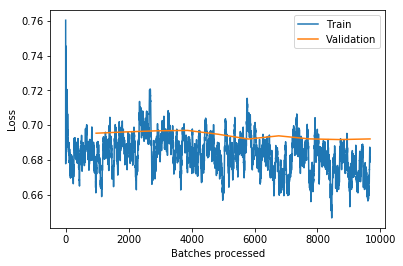

In [27]:
learn.recorder.plot_losses()

In [13]:
learn.fit_one_cycle(10, slice(lr))

NameError: name 'lr' is not defined

In [29]:
learn.save('vgg16stage1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


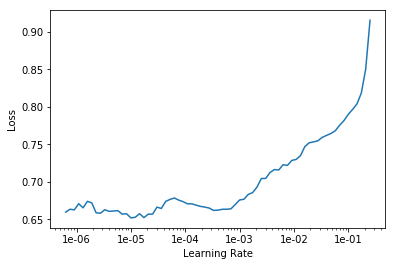

In [30]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [31]:
lr=0.001

In [32]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
1,0.668559,0.692733,0.718300,03:10
2,0.683403,0.730782,0.704670,03:10
3,0.693777,0.691103,0.719204,03:11
4,0.677323,0.788077,0.695433,03:11
5,0.670013,0.677399,0.722305,03:11
6,0.664242,0.678071,0.723790,03:11
7,0.630495,0.677930,0.725276,03:11
8,0.601863,0.683254,0.724824,03:11
9,0.588305,0.700961,0.718106,03:11
10,0.562194,0.705725,0.717525,03:11


# Saving the model 

In [33]:
learn.save('vgg16stage1')

In [34]:
learn.export()

In [318]:
learn.load('./vgg16stage1')

Learner(data=ImageDataBunch;

Train: LabelList (61927 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
uncertain,edema,no_edema,no_edema,edema
Path: .;

Valid: LabelList (15481 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
edema,no_edema,no_edema,edema,uncertain
Path: .;

Test: LabelList (202 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: ., model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1

# Testing the model

In [319]:
preds, _= learn.get_preds(ds_type=DatasetType.Test)

In [320]:
learn.data.test_ds.items

array(['./CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg',
       './CheXpert-v1.0-small/valid/patient64542/study1/view1_frontal.jpg',
       './CheXpert-v1.0-small/valid/patient64543/study1/view1_frontal.jpg',
       './CheXpert-v1.0-small/valid/patient64544/study1/view1_frontal.jpg', ...,
       './CheXpert-v1.0-small/valid/patient64737/study1/view1_frontal.jpg',
       './CheXpert-v1.0-small/valid/patient64738/study1/view1_frontal.jpg',
       './CheXpert-v1.0-small/valid/patient64739/study1/view1_frontal.jpg',
       './CheXpert-v1.0-small/valid/patient64740/study1/view1_frontal.jpg'], dtype='<U66')

In [321]:
thresh=0.3
learn.data.c2i

{'edema': 0, 'no_edema': 1, 'uncertain': 2}

In [322]:
learn.data.classes[0]

'edema'

In [323]:
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p >= thresh and p==max(pred)]) for pred in preds]
fnames = [f for f in learn.data.test_ds.items]
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])
print(df.head(10))

                                          image_name      tags
0  ./CheXpert-v1.0-small/valid/patient64541/study...  no_edema
1  ./CheXpert-v1.0-small/valid/patient64542/study...  no_edema
2  ./CheXpert-v1.0-small/valid/patient64543/study...     edema
3  ./CheXpert-v1.0-small/valid/patient64544/study...  no_edema
4  ./CheXpert-v1.0-small/valid/patient64545/study...     edema
5  ./CheXpert-v1.0-small/valid/patient64546/study...  no_edema
6  ./CheXpert-v1.0-small/valid/patient64547/study...  no_edema
7  ./CheXpert-v1.0-small/valid/patient64547/study...  no_edema
8  ./CheXpert-v1.0-small/valid/patient64548/study...     edema
9  ./CheXpert-v1.0-small/valid/patient64549/study...  no_edema


In [325]:
df.tags.replace(['uncertain', 'no_edema','edema'],[2,1,0], inplace=True)
y_pred=df.tags

In [327]:
y_pred.unique()

array([1, 0, 2])

In [328]:
test_df.Edema.unique()

array(['no_edema', 'edema'], dtype=object)

In [329]:
y_true=test_df.Edema.replace(['no_edema','edema'],[1,0], inplace=True)

In [330]:
y_true=test_df.Edema

# Obtaining Study metrics to evaluate model performance

In [331]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.metrics import recall_score,accuracy_score

              precision    recall  f1-score   support

           0       0.40      0.86      0.55        42
           1       0.97      0.66      0.79       160
           2       0.00      0.00      0.00         0

    accuracy                           0.70       202
   macro avg       0.46      0.51      0.45       202
weighted avg       0.85      0.70      0.74       202



/home/jupyter-tpisati/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


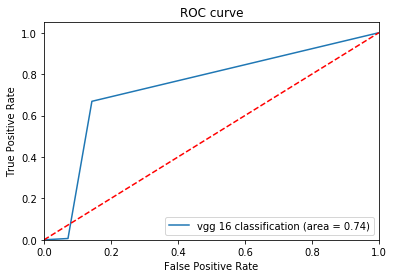

In [332]:
%matplotlib inline
import matplotlib.pyplot as plt
print(classification_report(y_true, y_pred))
Roc_auc = roc_auc_score(y_true, y_pred)
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr, label='vgg 16 classification (area = %0.2f)' % Roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig('ROC_curve')
plt.show()